## Reserve resources on FABRIC

In this section, we’ll reserve and configure resources on the FABRIC testbed.

### Configure environment

In [1]:
from fabrictestbed_extensions.fablib.fablib import FablibManager as fablib_manager
fablib = fablib_manager() 
conf = fablib.show_config()

Credential Manager,cm.fabric-testbed.net
Orchestrator,orchestrator.fabric-testbed.net
Token File,/home/fabric/.tokens.json
Project ID,6ce270de-788d-4e07-8bae-3206860a6387
Bastion Username,smbalte_0000108220
Bastion Private Key File,/home/fabric/work/fabric_config/fabric_bastion_key
Bastion Host,bastion.fabric-testbed.net
Bastion Private Key Passphrase,None
Slice Public Key File,/home/fabric/work/fabric_config/slice_key.pub
Slice Private Key File,/home/fabric/work/fabric_config/slice_key
Slice Private Key Passphrase,None


### Define FABRIC configuration for adaptive video experiment

In [2]:
slice_name="vsr-part1-" + fablib.get_bastion_username()

node_conf = [
 {'name': "server",   'cores': 2, 'ram': 4, 'disk': 20, 'image': 'default_ubuntu_20', 'packages': ['net-tools']}, 
 {'name': "client",  'cores': 2, 'ram': 4, 'disk': 20, 'image': 'default_ubuntu_20', 'packages': ['net-tools']}, 
 {'name': "p4_switch",  'cores': 32, 'ram': 16, 'disk': 40, 'image': 'default_ubuntu_20', 'packages': ['net-tools']}
]
net_conf = [
 {"name": "net_r", "subnet": "10.10.1.0/24", "nodes": [{"name": "server1",  "addr": "10.10.1.100"}, {"name": "p4_switch", "addr": "10.10.1.10"}]},
 {"name": "net_j", "subnet": "10.10.2.0/24", "nodes": [{"name": "server2", "addr": "10.10.2.100"}, {"name": "p4_switch", "addr": "10.10.2.10"}]},
]
route_conf = [
 {"addr": "10.10.1.0/24", "gw": "10.10.2.10", "nodes": ["server1"]}, 
 {"addr": "10.10.2.0/24", "gw": "10.10.1.10", "nodes": ["server2"]}
]
exp_conf = {'cores': sum([ n['cores'] for n in node_conf]), 'nic': sum([len(n['nodes']) for n in net_conf]) }

### Reserve resources

Now, we are ready to reserve resources!

First, make sure you don’t already have a slice with this name:

In [4]:
try:
    slice = fablib.get_slice(slice_name)
    print("You already have a slice by this name!")
    print("If you previously reserved resources, skip to the 'log in to resources' section.")
except:
    print("You don't have a slice named %s yet." % slice_name)
    print("Continue to the next step to make one.")
    slice = fablib.new_slice(name=slice_name)

You don't have a slice named vsr-part1-smbalte_0000108220 yet.
Continue to the next step to make one.


In [10]:
#This is only to restart the slice creation process
slice.delete()

In [13]:
#This is only to check the status of a pre-existing slice
slice.update()
_ = slice.show()

ID,5a8943f1-91bf-4370-93fd-264347a50a45
Name,vsr-part1-smbalte_0000108220
Lease Expiration (UTC),2023-12-07 23:30:54 +0000
Lease Start (UTC),2023-12-06 23:30:54 +0000
Project ID,6ce270de-788d-4e07-8bae-3206860a6387
State,Dead


We will select a random site that has sufficient resources for our experiment:

In [6]:
while True:
    site_name = fablib.get_random_site()
    if ( (fablib.resources.get_core_available(site_name) > 1.2*exp_conf['cores']) and
        (fablib.resources.get_component_available(site_name, 'SharedNIC-ConnectX-6') > 1.2**exp_conf['nic']) ):
        break

fablib.show_site(site_name)

Name,DALL
State,Active
Address,"1950 N Stemmons Fwy,Dallas TX 75207"
Location,"(32.79908160563668, -96.82069027727609)"
Hosts,3
CPUs,6
Cores Available,202
Cores Capacity,384
Cores Allocated,182
RAM Available,1202
RAM Capacity,1506


'<pandas.io.formats.style.Styler object at 0x7f0a21813010>'

Then we will add hosts and network segments:

In [7]:
# this cell sets up the nodes
server = slice.add_node(name="server", 
                      site=site_name, 
                      cores=4, 
                      ram=8, 
                      disk=20, 
                      image='default_ubuntu_20')

client = slice.add_node(name="client", 
                      site=site_name, 
                      cores=4, 
                      ram=8, 
                      disk=20, 
                      image='default_ubuntu_20')

switch = slice.add_node(name="switch", 
                      site=site_name, 
                      cores=32, 
                      ram=16, 
                      disk=40, 
                      image='default_ubuntu_20')

In [8]:
# this cell sets up the network segments and interfaces
server_iface = server.add_component(model='NIC_Basic').get_interfaces()[0]
client_iface = client.add_component(model='NIC_Basic').get_interfaces()[0]

switch_iface1 = switch.add_component(model='NIC_Basic', name='net1_nic').get_interfaces()[0]
switch_iface2 = switch.add_component(model='NIC_Basic', name='net2_nic').get_interfaces()[0]

net1 = slice.add_l2network(name='net1', interfaces=[server_iface, switch_iface1])
net2 = slice.add_l2network(name='net2', interfaces=[switch_iface2, client_iface])

In [9]:
# this cell will add a GPU to the 'router' node
my_gpu = slice.get_node(name="switch").add_component(model="GPU_RTX6000", name="VSR_GPU")

The following cell submits our request to the FABRIC site. The output of this cell will update automatically as the status of our request changes.

-   While it is being prepared, the “State” of the slice will appear as “Configuring”.
-   When it is ready, the “State” of the slice will change to “StableOK”.

You may prefer to walk away and come back in a few minutes (for simple slices) or a few tens of minutes (for more complicated slices with many resources).

In [10]:
slice.submit()


Retry: 10, Time: 319 sec


ID,09161bce-82e9-48a5-aa06-c46ceb06a8c1
Name,vsr-part1-smbalte_0000108220
Lease Expiration (UTC),2023-12-07 23:42:59 +0000
Lease Start (UTC),2023-12-06 23:43:00 +0000
Project ID,6ce270de-788d-4e07-8bae-3206860a6387
State,StableOK


ID,Name,Cores,RAM,Disk,Image,Image Type,Host,Site,Username,Management IP,State,Error,SSH Command,Public SSH Key File,Private SSH Key File
aaca3f44-877a-48d7-85bf-0901269b48ad,client,4,8,100,default_ubuntu_20,qcow2,dall-w1.fabric-testbed.net,DALL,ubuntu,2001:400:a100:3000:f816:3eff:fe7b:c2c9,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3000:f816:3eff:fe7b:c2c9,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
369cd5a0-4eb5-4ffc-834f-5c7b726c5ec5,server,4,8,100,default_ubuntu_20,qcow2,dall-w1.fabric-testbed.net,DALL,ubuntu,2001:400:a100:3000:f816:3eff:fee6:db8d,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3000:f816:3eff:fee6:db8d,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
543851dc-7ecf-43c4-a669-c58d873e03d8,switch,32,16,100,default_ubuntu_20,qcow2,dall-w1.fabric-testbed.net,DALL,ubuntu,2001:400:a100:3000:f816:3eff:fe58:8d36,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3000:f816:3eff:fe58:8d36,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key


ID,Name,Layer,Type,Site,Subnet,Gateway,State,Error
41c83342-c9a9-4650-bd2f-58addaf43416,net1,L2,L2Bridge,DALL,None,None,Active,
edf29a47-451f-4a6b-bbaa-e11603c25ccd,net2,L2,L2Bridge,DALL,None,None,Active,


Name,Short Name,Node,Network,Bandwidth,Mode,VLAN,MAC,Physical Device,Device,IP Address,Numa Node
server-None-p1,p1,server,net1,100,config,,0E:0A:CD:51:48:0A,enp7s0,enp7s0,None,6
client-None-p1,p1,client,net2,100,config,,26:7D:17:66:29:7A,enp7s0,enp7s0,None,6
switch-net2_nic-p1,p1,switch,net2,100,config,,2A:03:B6:5C:CF:62,enp7s0,enp7s0,None,6
switch-net1_nic-p1,p1,switch,net1,100,config,,2A:AB:17:54:4D:99,enp8s0,enp8s0,None,6



Time to print interfaces 326 seconds


'09161bce-82e9-48a5-aa06-c46ceb06a8c1'

In [11]:
slice.get_state()
slice.wait_ssh(progress=True)

Waiting for slice . Slice state: StableOK
Waiting for ssh in slice . ssh successful


True

### Configure resources

Next, we will configure the resources so they are ready to use.

In [12]:
slice = fablib.get_slice(name=slice_name)

In [13]:
#Installing BMv2 on the switch
#DO THIS MANUALLY ONCE YOU LOG IN TO THE SERVER. DOING IT HERE DOES NOT WORK https://github.com/p4lang/p4c
switch = slice.get_node(name="switch")     
#switch.upload_file('install_bmv2.sh', 'install_bmv2.sh')
#stdout, stderr = switch.execute(f'chmod +x install_bmv2.sh &&  ./install_bmv2.sh',quiet=True)
switch.execute('. /etc/os-release')
switch.execute('echo "deb https://download.opensuse.org/repositories/home:/p4lang/xUbuntu_${VERSION_ID}/ /" | sudo tee /etc/apt/sources.list.d/home:p4lang.list')
switch.execute('curl -L "https://download.opensuse.org/repositories/home:/p4lang/xUbuntu_${VERSION_ID}/Release.key" | sudo apt-key add -')
switch.execute('sudo apt-get update')
switch.execute('sudo apt install -y p4lang-p4c')

deb https://download.opensuse.org/repositories/home:/p4lang/xUbuntu_/ /
   % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: apt-key output should not be parsed (stdout is not a terminal)
100  1083    0  1083    0     0   1787      0 --:--:-- --:--:-- --:--:--  1787
gpg: no valid OpenPGP data found.
 Hit:1 http://nova.clouds.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://nova.clouds.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:4 http://nova.clouds.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:5 http://nova.clouds.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Ign:6 https://download.opensuse.org/repositories/home:/p4lang/xUbuntu_  InRelease
Get:7 http://nova.clo

('Reading package lists...\nBuilding dependency tree...\nReading state information...\n',
 '\nWARNING: apt does not have a stable CLI interface. Use with caution in scripts.\n\nE: Unable to locate package p4lang-p4c\n')

In [16]:
# install packages
server = slice.get_node(name="server")
client = slice.get_node(name="client")
stdout, stderr = server.execute(f'sudo apt-get install -y net-tools', quiet=True)
stdout, stderr = client.execute(f'sudo apt-get install -y net-tools', quiet=True)
stdout, stderr = switch.execute(f'sudo apt-get install -y net-tools', quiet=True)

In [22]:
#Getting the names of the interfaces
server = slice.get_node(name="server")
client = slice.get_node(name="client")

node1_iface = server.get_interface(network_name='net1') 
server_iface_name = node1_iface.get_device_name()
print(f'server_iface: {server_iface_name}')

node2_iface = client.get_interface(network_name='net2') 
client_iface_name = node2_iface.get_device_name()
print(f'client_iface: {client_iface_name}')

switch_iface1 = switch.get_interface(network_name='net1') 
switch_iface1_name = switch_iface1.get_device_name()
print(f'switch_iface1: {switch_iface1_name}')

switch_iface2 = switch.get_interface(network_name='net2') 
switch_iface2_name = switch_iface2.get_device_name()
print(f'switch_iface2: {switch_iface2_name}')

server_iface: enp7s0
client_iface: enp7s0
switch_iface1: enp8s0
switch_iface2: enp7s0


In [23]:
#Starting up all the interfaces
stdout, stderr = server.execute(f'sudo ip link set dev {server_iface_name} up', quiet=True)
stdout, stderr = client.execute(f'sudo ip link set dev {client_iface_name} up', quiet=True)
stdout, stderr = switch.execute(f'sudo ip link set dev {switch_iface1_name} up', quiet=True)
stdout, stderr = switch.execute(f'sudo ip link set dev {switch_iface2_name} up', quiet=True)

In [24]:
#Hardcoding all MAC addresses for simplicity
server_iface_MAC = '00:00:00:00:00:01'
switch_iface1_MAC = '00:00:00:00:00:02'
switch_iface2_MAC = '00:00:00:00:00:03'
client_iface_MAC = '00:00:00:00:00:04'

In [25]:
#Configuring IP and MAC between server and switch_iface1
server_switch_subnet = "192.168.1.0/24"
server_ip = '192.168.1.10/24'
switch_ip1 = '192.168.1.1/24'

stdout, stderr = server1.execute(f'sudo ifconfig {server_iface_name} {server_ip}')
stdout, stderr = switch.execute(f'sudo ifconfig {switch_iface1_name} {switch_ip1}')

stdout, stderr = server.execute(f'sudo ifconfig {server_iface_name} hw ether {server_iface_MAC}')
stdout, stderr = switch.execute(f'sudo ifconfig {switch_iface1_name} hw ether {switch_iface1_MAC}')

In [26]:
#Configuring IP and MAC between server2 and switch_iface2
client_switch_subnet = "192.168.2.0/24"
client_ip = '192.168.2.10/24'
switch_ip2 = '192.168.2.1/24'

stdout, stderr = client.execute(f'sudo ifconfig {client_iface_name} {client_ip}')
stdout, stderr = switch.execute(f'sudo ifconfig {switch_iface2_name} {switch_ip2}')

stdout, stderr = client.execute(f'sudo ifconfig {client_iface_name} hw ether {client_iface_MAC}')
stdout, stderr = switch.execute(f'sudo ifconfig {switch_iface2_name} hw ether {switch_iface2_MAC}')

In [27]:
#Enable IP forwarding on the switch
stdout, stderr = switch.execute('sudo sysctl -w net.ipv4.ip_forward=1' , quiet=True)

In [29]:
# Deleting the routing tables for our servers so all traffic goes only from switch
stdout, stderr = switch.execute(f'sudo ip route del {server_switch_subnet}', quiet=True)
stdout, stderr = switch.execute(f'sudo ip route del {client_switch_subnet}', quiet=True)

In [30]:
#Configuring routing
gw1 = switch_ip1.split('/')[0] # gw1 -> 192.168.1.1 
gw2 = switch_ip2.split('/')[0] # gw2 -> 192.168.2.1
stdout, stderr = server.execute(f'sudo ip route add {client_switch_subnet} via {gw1}')
stdout, stderr = client.execute(f'sudo ip route add {server_switch_subnet} via {gw2}')

In [31]:
#Configuring ARP
stdout, stderr = server.execute(f'sudo arp -s {gw1} {switch_iface1_MAC}')
stdout, stderr = client.execute(f'sudo arp -s {gw2} {switch_iface2_MAC}')

### Extend your slice

If you don’t plan to finish an experiment in one day, you can extend your slice. The following cell extends your reservation for 7 days.

In [32]:
from datetime import datetime
from datetime import timezone
from datetime import timedelta

# Set end date to 7 days from now
end_date = (datetime.now(timezone.utc) + timedelta(days=7)).strftime("%Y-%m-%d %H:%M:%S %z")
slice.renew(end_date)

### Draw the network topology

The following cell will draw the network topology, for your reference. The interface name and addresses of each experiment interface will be shown on the drawing.

In [33]:
l2_nets = [(n.get_name(), {'color': 'lavender'}) for n in slice.get_l2networks() ]
l3_nets = [(n.get_name(), {'color': 'pink'}) for n in slice.get_l3networks() ]
hosts   =   [(n.get_name(), {'color': 'lightblue'}) for n in slice.get_nodes()]
nodes = l2_nets + l3_nets + hosts
ifaces = [iface.toDict() for iface in slice.get_interfaces()]
edges = [(iface['network'], iface['node'], 
          {'label': iface['physical_dev'] + '\n' + iface['ip_addr'] + '\n' + iface['mac']}) for iface in ifaces]

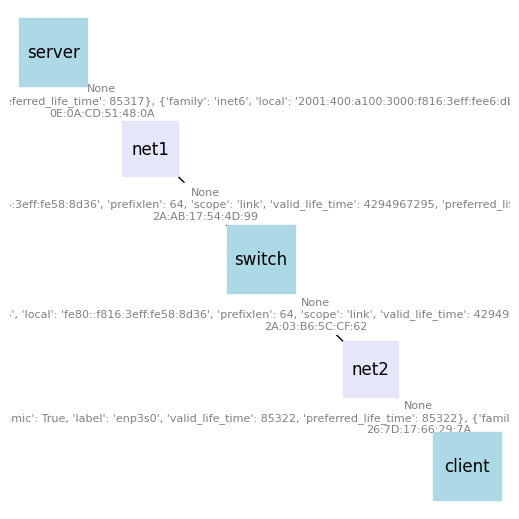

In [34]:
import networkx as nx
import matplotlib.pyplot as plt
plt.figure(figsize=(len(nodes),len(nodes)))
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
pos = nx.spring_layout(G)
nx.draw(G, pos, node_shape='s',  
        node_color=[n[1]['color'] for n in nodes], 
        node_size=[len(n[0])*400 for n in nodes],  
        with_labels=True);
nx.draw_networkx_edge_labels(G,pos,
                             edge_labels=nx.get_edge_attributes(G,'label'),
                             font_color='gray',  font_size=8, rotate=False);

### Log into resources

Now, we are finally ready to log in to our resources over SSH! Run the following cells, and observe the table output - you will see an SSH command for each of the resources in your topology.

In [35]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
slice_info = [{'Name': n.get_name(), 'SSH command': n.get_ssh_command()} for n in slice.get_nodes()]
pd.DataFrame(slice_info).set_index('Name')

,SSH command
Name,
server,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3000:f816:3eff:fee6:db8d
client,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3000:f816:3eff:fe7b:c2c9
switch,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3000:f816:3eff:fe58:8d36


Now, you can open an SSH session on any of the resources as follows:

-   in Jupyter, from the menu bar, use File \> New \> Terminal to open a new terminal.
-   copy an SSH command from the table, and paste it into the terminal. (Note that each SSH command is a single line, even if the display wraps the text to a second line! When you copy and paste it, paste it all together.)

You can repeat this process (open several terminals) to start a session on each resource. Each terminal session will have a tab in the Jupyter environment, so that you can easily switch between them.

In [ ]:
#Uploading the P4 Files in the switch (Does not usually work, log in with ssh and create, compile files manually)
switch.upload_file('p4files/basic.p4', '/VSR_P4/basic.p4')
switch.upload_file('p4files/checksum.p4', '/VSR_P4/checksum.p4') 
switch.upload_file('p4files/deparser.p4', '/VSR_P4/deparser.p4') 
switch.upload_file('p4files/egress.p4', '/VSR_P4/egress.p4')
switch.upload_file('p4files/headers.p4', '/VSR_P4/headers.p4') 
switch.upload_file('p4files/ingress.p4', '/VSR_P4/ingress.p4') 
switch.upload_file('p4files/parser.p4', '/VSR_P4/parser.p4') 
#Compilation commands - 
# $p4c basic.p4
# $sudo simple_switch -i 0@ens8 -i 1@ens7 basic.json --log-console

In [41]:
#Populate the forwarding table from the control plane after compiling the P4 files. 
#Upload rules.sh and run the following command on the switch-
# $chmod +x rules.sh && ./rules.sh
stdout, stderr = switch.execute(f'chmod +x rules.sh && ./rules.sh', quiet=True)

In [38]:
#Installing scapy on server and client
stdout, stderr = server.execute(f'sudo apt-get update && sudo apt-get install -y python3-scapy', quiet=True)
stdout, stderr = client.execute(f'sudo apt-get update && sudo apt-get install -y python3-scapy', quiet=True)

In [ ]:
#Sending a packet from server to switch for testing. Upload p4files/send.py to server
# $sudo python3 send.py enp7s0 192.168.1.10 192.168.2.10 HelloWorld

In [ ]:
#Getting the video files on the server (Run these commands on the server node)
# $sudo apt install -y apache2
# $wget https://nyu.box.com/shared/static/d6btpwf5lqmkqh53b52ynhmfthh2qtby.tgz -O media.tgz
# $sudo tar -v -xzf media.tgz -C /var/www/html/

#Now get the video encoding utility on the client
# $sudo apt install -y python3 ffmpeg